## Feature Engineering Improvements

Added new key words to furniture, decorative object, print category.
Corrected spelling of terms and added works to print category.
Remove length check from long list of items
Added new feature **sculpture_keywords()**

In [1]:
import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import auth
from comet_ml import Experiment

from feature_engineering import functions
from utils import utils
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Import MoMA dataset

df = pd.read_csv('data/moma_baseline_model_balanced_dataset_05_11_2011.csv')

In [3]:
# assign column names

title_desc_col = 'Title'
medium_col = 'Medium'
dimension_col = 'Dimensions'
url_col = 'ThumbnailURL'


In [4]:
# Re-compute features
df_transformed = functions.text_based_transformer(df
                                        , medium=medium_col
                                        , dimensions=dimension_col
                                        , title=title_desc_col)

In [5]:
df_transformed_1 = functions.is_drawing(df_transformed)

df_transformed_1['long_list_of_things'] = df_transformed_1[medium_col].apply(lambda x: 
                                                                    functions.long_list_of_things(str(x)))

df = df_transformed_1

/Users/katielazell-fairman/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [6]:
print(df.shape)

df[['index', 'Classification']].groupby('Classification').count().sort_values('index', ascending=False)

(5340, 45)


,index
Classification,
Drawing,750
Painting,750
Photograph,750
Print,750
Sculpture,750
decorative_object,750
furniture,504
Installation,336


In [7]:
# Select columns to use as featureset

cols_to_use = ['long_list_of_things'
        , 'installation_keyword'
        , 'print_keyword'
        , 'drawing_paper_word'
        , 'drawing_keyword'
        , 'painting_keyword'
        , 'photo_keyword'
        , 'has_3dimensions'
        , 'furniture_keyword'
        , 'sculpture_keyword'
        , 'decorative_obj_keyword'
        , 'decorative_obj_keyword_med'
        , 'is_drawing'
              ]

In [8]:
#Create labels & Training data 

y = pd.get_dummies(df['Classification'])

X = df[cols_to_use]

In [9]:
# Segragate Data into test, train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=88)


In [10]:
y_test

,Drawing,Installation,Painting,Photograph,Print,Sculpture,decorative_object,furniture
5312,0,0,0,0,0,0,0,1
466,0,0,0,0,1,0,0,0
4899,0,0,0,0,0,0,0,1
1987,0,0,0,1,0,0,0,0
4522,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
3253,0,0,0,0,0,1,0,0
3464,0,0,0,0,0,1,0,0
2601,0,0,1,0,0,0,0,0
3936,0,1,0,0,0,0,0,0


## Test with Baseline Heuristic Model

In [11]:
# Manual Logic Predictor

def if_then_classifier(y_test):

    y_pred_manual = np.array([y_test.columns])

    for index, row in X_test.iterrows():
        if row['print_keyword']:
            result= [0,0,0,0,1,0,0,0]
        elif row['photo_keyword']:
            result= [0,0,0,1,0,0,0,0]
        elif row['decorative_obj_keyword']:
            result= [0,0,0,0,0,0,1,0]
        elif row['furniture_keyword']:
            result= [0,0,0,0,0,0,0,1]
        elif row['is_drawing'].any():
            result= [1,0,0,0,0,0,0,0]
        elif row['has_3dimensions']:
            if row['installation_keyword']:
                result = [0,1,0,0,0,0,0,0]
            elif row['sculpture_keyword']: # <------ New section added
                result = [0,0,0,0,0,1,0,0]
            elif row['long_list_of_things']:
                    result = [0,1,0,0,0,0,0,0]  
            else:
                result = [0,0,0,0,0,1,0,0]
        elif row['painting_keyword']:
            result = [0,0,1,0,0,0,0,0]
        else:
            result = [0,0,0,0,0,0,0,0]
        y_pred_manual = np.vstack((y_pred_manual, result))
        
    y_pred_manual_final = pd.DataFrame(y_pred_manual[1:,]
                                   , columns=y_test.columns
                                   , index=X_test.index).astype('int')
    return y_pred_manual_final

In [12]:
y_pred_manual_final = if_then_classifier(y_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred_manual_final)
print(accuracy)

0.8080524344569289


In [14]:
report = classification_report(y_test, y_pred_manual_final, target_names=y_test.columns)
print(report)

                   precision    recall  f1-score   support

          Drawing       0.87      0.91      0.89       306
     Installation       0.37      0.12      0.18       150
         Painting       0.93      0.78      0.85       316
       Photograph       0.93      0.92      0.92       293
            Print       0.94      0.91      0.92       264
        Sculpture       0.82      0.67      0.74       295
decorative_object       0.94      0.88      0.91       310
        furniture       0.93      0.99      0.96       202

        micro avg       0.89      0.81      0.85      2136
        macro avg       0.84      0.77      0.80      2136
     weighted avg       0.87      0.81      0.83      2136
      samples avg       0.81      0.81      0.81      2136



/Users/katielazell-fairman/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
experiment = Experiment(api_key=auth.comet_api_key,
                         project_name="artwork-classification", workspace="lazell")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/lazell/artwork-classification/fd45382230e24d38a124241a0aae4c7f



In [31]:
# Create an comet.ml experiment

experiment.add_tag('Baseline Model with v3 of features')
experiment.log_metric("accuracy", accuracy)

experiment.log_metric("f1-score micro", 0.85)
experiment.log_metric("f1-score macro", 0.80)
experiment.log_metric("f1-score weighted", 0.83)

experiment.log_metric("precision micro", 0.89)
experiment.log_metric("precision macro", 0.84)
experiment.log_metric("precision weighted", 0.87)

experiment.log_metric("recall micro", 0.81)
experiment.log_metric("recall macro", 0.77)
experiment.log_metric("recall weighted", 0.81)

## Descision Tree Classifier

In [32]:
# Train Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

experiment = Experiment(api_key=auth.comet_api_key,
                         project_name="artwork-classification", workspace="lazell")

experiment.add_tag('Model 3 - DecisionTree Classifier with v3 of features')

clf = DecisionTreeClassifier(min_samples_split=5
                             ,max_depth=10
                             ).fit(X_train, y_train)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/lazell/artwork-classification/fd45382230e24d38a124241a0aae4c7f
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [2]           : 0.8080524344569289
COMET INFO:     f1-score macro [2]     : (0.79, 0.8)
COMET INFO:     f1-score micro [2]     : (0.84, 0.85)
COMET INFO:     f1-score weighted [2]  : 0.83
COMET INFO:     precision macro [2]    : 0.84
COMET INFO:     precision micro [2]    : 0.89
COMET INFO:     precision weighted [2] : 0.87
COMET INFO:     recall macro [2]       : 0.77
COMET INFO:     recall micro [2]       : (0.8, 0.81)
COMET INFO:     recall weighted [2]    : (0.8, 0.81)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata        

In [35]:
experiment.end

<bound method BaseExperiment.end of <comet_ml.Experiment object at 0x125ef9c70>>

In [33]:
# Get Test Results

results = clf.predict(X_test)
y_pred = pd.DataFrame(columns=y_test.columns
                      , data=results
                      , index=X_test.index)

In [34]:
accuracy = accuracy_score(y_test, y_pred_manual_final)
print(accuracy)

0.8080524344569289


In [20]:
report = classification_report(y_test, y_pred_manual_final, target_names=y_test.columns)
print(report)

                   precision    recall  f1-score   support

          Drawing       0.87      0.91      0.89       306
     Installation       0.37      0.12      0.18       150
         Painting       0.93      0.78      0.85       316
       Photograph       0.93      0.92      0.92       293
            Print       0.94      0.91      0.92       264
        Sculpture       0.82      0.67      0.74       295
decorative_object       0.94      0.88      0.91       310
        furniture       0.93      0.99      0.96       202

        micro avg       0.89      0.81      0.85      2136
        macro avg       0.84      0.77      0.80      2136
     weighted avg       0.87      0.81      0.83      2136
      samples avg       0.81      0.81      0.81      2136



/Users/katielazell-fairman/.pyenv/versions/3.8.0/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Get Feature Importances
df_feature_importances = pd.DataFrame(data=clf.feature_importances_
                                      ,index=X_train.columns).sort_values(0, ascending=False)
df_feature_importances

,0
print_keyword,0.175838
photo_keyword,0.161654
decorative_obj_keyword,0.151461
is_drawing,0.133653
furniture_keyword,0.126680
has_3dimensions,0.106998
painting_keyword,0.067738
installation_keyword,0.033267
decorative_obj_keyword_med,0.019381
drawing_paper_word,0.011562


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

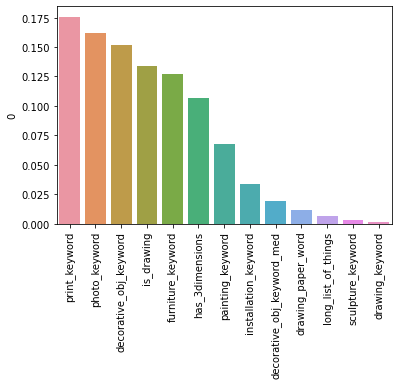

In [22]:
# Plot Importances

sns.barplot(y=df_feature_importances[0],x=df_feature_importances.index)
plt.xticks(rotation='vertical')

In [23]:
# Save to model

model = {'model': clf,
         'features': cols_to_use,
         'labels' : list(y_train.columns)}

pkl_filename = "model_3_DecisionTreeClassifier_v2features.pkl"
with open('./models/'+pkl_filename, 'wb') as file:
    pickle.dump(model, file)

## Test on Picasso Dataset

In [24]:
# Import Validation data

df_picasso_test = pd.read_csv('./data/data-1589261181890-picasso-christies-test.csv')

In [25]:
# assign column names

title_desc_col = 'title'
medium_col = 'details'
dimension_col = 'details'
url_col = 'image_url'


In [26]:
df_transformed_1 = functions.text_based_transformer(df_picasso_test
                                        , medium=medium_col
                                        , dimensions=dimension_col
                                        , title=title_desc_col)

df_transformed_2 = functions.is_drawing(df_transformed_1)

df_transformed_2['long_list_of_things'] = df_transformed_2['details'].apply(lambda x: functions.long_list_of_things(str(x)))

df = df_transformed_2

/Users/katielazell-fairman/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/core/computation/expressions.py:190: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [27]:
# Get Test Results

results = clf.predict(df[cols_to_use])
y_pred = pd.DataFrame(columns=y_test.columns
                      , data=results
                      , index=df.index)

# crwate label for the not classified result

y_pred['no_classification'] = y_pred.apply(lambda x: 1 if sum(x) == 0 else 0, axis=1)

In [28]:
x = y_pred.stack()
results = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

results[50:]

50             Painting
51    decorative_object
52             Painting
53    decorative_object
54    decorative_object
55         Installation
56            Sculpture
57    no_classification
58              Drawing
59            Sculpture
60    decorative_object
61         Installation
62             Painting
63              Drawing
64             Painting
65              Drawing
66    decorative_object
67    decorative_object
68              Drawing
69            Sculpture
70    decorative_object
71              Drawing
72    no_classification
73    no_classification
74    decorative_object
75             Painting
76             Painting
77    no_classification
78    no_classification
79             Painting
80    decorative_object
81    no_classification
82    no_classification
83    no_classification
84             Painting
85         Installation
86              Drawing
87    decorative_object
88            Sculpture
89                Print
90              Drawing
91    no_classif

In [29]:
utils.view_images_from_url(df, url_col, subsample=False)

0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


In [30]:
results = pd.DataFrame(results)
results

,0
0,Drawing
1,decorative_object
2,Painting
3,no_classification
4,Drawing
...,...
95,Drawing
96,Drawing
97,Drawing
98,decorative_object


## Manual Assesment

Accuracy: 0.80

some drawings are not identified
decorative objects perform well
There's an edge case where a painted wooden sculpture was classified as a painting.